<a href="https://colab.research.google.com/github/irenewuuuu/Mobile-Game-A-B-testing/blob/main/Mobile_game_player_retention_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobile game player rentention A/B tessting
Conduct A/B testing to analyze whether a new feature can improve the retention rate of players.

# 0.background
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>
<p>As players progress through the levels of the game, they will <strong>occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress</strong>. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.<p>But where should the gates be placed? Initially the first gate was placed at level 30. <strong>In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.</strong> </p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

# 1.enviroment set up and data import

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('cookie_cats').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# print(rows)

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows)

In [45]:
df.head()

,0,1,2,3,4
0,userid,version,sum_gamerounds,retention_1,retention_7
1,116,gate_30,3,FALSE,FALSE
2,337,gate_30,38,TRUE,FALSE
3,377,gate_40,165,TRUE,FALSE
4,483,gate_40,1,FALSE,FALSE


In [46]:
# set first row as column name and remove first row
df.columns=df.iloc[0]
df= df[1:]

In [47]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
1,116,gate_30,3,FALSE,FALSE
2,337,gate_30,38,TRUE,FALSE
3,377,gate_40,165,TRUE,FALSE
4,483,gate_40,1,FALSE,FALSE
5,488,gate_40,179,TRUE,TRUE


## 1.1 checking missing value and duplicated userid

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 1 to 90189
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  object
 3   retention_1     90189 non-null  object
 4   retention_7     90189 non-null  object
dtypes: object(5)
memory usage: 3.4+ MB


<p>The data is from 90,189 players that installed the game while the AB-test was running. no missing value. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after install
<li><code>retention_1</code> - did the player come back and play 1 day after SEE THE GATE?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after SEE THE GATE?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>


In [49]:
# convert data type as needed
df['sum_gamerounds']=pd.to_numeric(df['sum_gamerounds'])
df['retention_1'] = df['retention_1'].replace({'TRUE': True, 'FALSE':False})
df['retention_7'] = df['retention_7'].replace({'TRUE': True, 'FALSE':False})


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 1 to 90189
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(1), object(2)
memory usage: 2.2+ MB


In [51]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
1,116,gate_30,3,False,False
2,337,gate_30,38,True,False
3,377,gate_40,165,True,False
4,483,gate_40,1,False,False
5,488,gate_40,179,True,True


In [52]:
df.groupby('version').agg({'userid':'count','sum_gamerounds':'mean','retention_1':'mean', 'retention_7':'mean'})

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,52.456264,0.448188,0.190201
gate_40,45489,51.298776,0.442283,0.182000


When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The number of players is roughly the same in the control and test group, the data set is balanced from version perspective.

***correlation analysis***

# 2.Analyze player behaviour

In [53]:
df.describe()

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


looks like the data set is skewed with 75% users played 51 or less rounds of game while the maximum reached 50k. Let's build a box plot to visualize the distribution.

<Axes: >

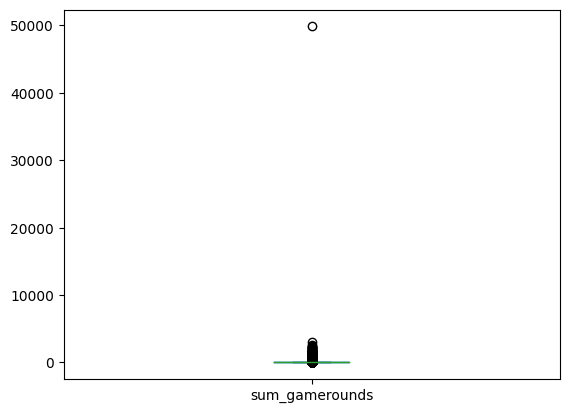

In [54]:
df['sum_gamerounds'].plot.box()

The box plot is clearly showing an outlier, who played ~50k rounds of game, while all other players played less than 10k rounds of game.

In [14]:
# count number of players grouped by number of game rounds played
df2 = df.groupby('sum_gamerounds')['userid'].count()
df2

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

In [15]:
print(round(df2[:7].sum()/df2.sum()*100,0),'% played 7 or less rounds during first week')
print(round(df2[:20].sum()/df2.sum()*100,0),'% played 20 or less rounds during first week')


31.0 % played 7 or less rounds during first week
54.0 % played 20 or less rounds during first week


Text(0.5, 0, '# Game rounds')

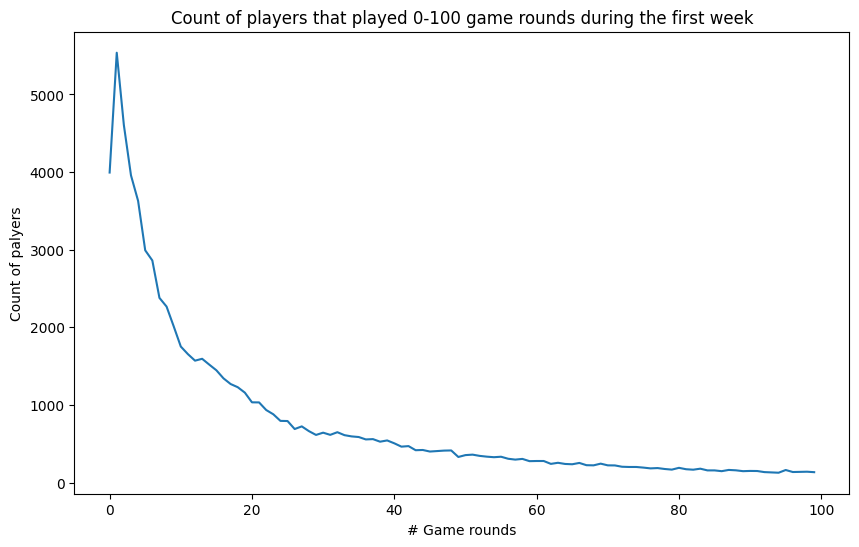

In [16]:
# plot the distribution of players that played 100 or less rounds during their first week playing the game
ax=df2[:100].plot(figsize=(10,6))
ax.set_title('Count of players that played 0-100 game rounds during the first week')
ax.set_ylabel('Count of palyers')
ax.set_xlabel('# Game rounds')


*what's the diff between plt and ax?*


* Half of the players played 20 or less rounds within the first week
* a third of players played 7 or less rounds within the first week, which is less than 1 round daily
* around 4k players haven't started playing within the first week of download of the app, why the didn't play after download, what percentage of these players will comeback to play within a month/quarter/year?
** was attracted by other games
** distracted and no time to play
**





# 3.comparing 1-day retention

A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: the percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

## 3.1 overall 1-day retention

In [17]:
df['retention_1'].mean()

0.4452095044850259

overall speaking, 44% of player came back within one day after installing the game.

## 3.2 1-day retention for each A/B group

In [18]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

the 1-day retention rate slightly dropped when the gate moved from 30 to 40 (from 44.81% to 44.23%). Is this significant enough for us to be certain that 1-day retention rate changed after the gate was moved to 40 from 30. I'll use two methods to test the difference between 1-day retention of these two versions:
* bootstrapping
* z-test

### 3.2.1 bootstrapping

In [19]:
df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
# frac: fraction of data to sample, here I put 1 means, each time will sample 90189 times from the data set,
# but beacuse sampling with replacements, there will be record been sampled multiple times, so that each time the average
# retention rate will be different


version
gate_30    0.446675
gate_40    0.445027
Name: retention_1, dtype: float64

<Axes: ylabel='Density'>

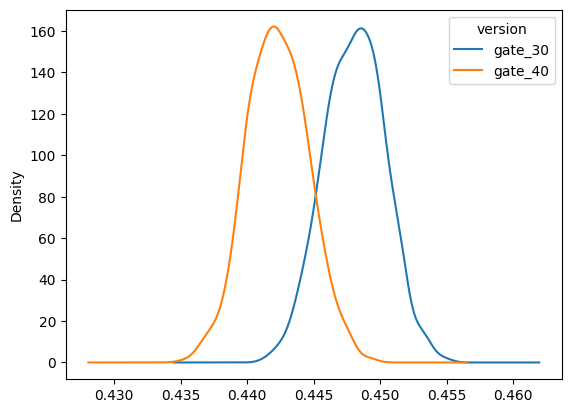

In [20]:
# creating an list with bootstrapped means for each AB-group
boot_1d = []

for i in range(1000):
  boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
  boot_1d.append(boot_mean)

# transforming the list to DataFrame
boot_1d = pd.DataFrame(boot_1d)

# A kernel density estimate plot of the boot strap distributions
boot_1d.plot(kind='density')

the plot above is showing a difference in the average 1-day retention rate that obtained from 1000 times of sampling. looks like when gate is at 30, it is more likely that 1-day retention rate being higher.
let's plot the % difference to get a closer look.

notes: *A kernel density plot (KDE)* is a non-parametric way to estimate the probability density function of a continuous random variable. It provides a smooth, continuous representation of the data distribution, which can be helpful for visualizing and understanding the underlying data distribution.

Here are the key features of a kernel density plot:

**Smoothness**: Unlike a histogram, which discretizes the data into bins, a KDE represents the data distribution as a smooth curve. This curve is created by placing a kernel (a smooth, symmetric function) at each data point and summing these kernels to create the overall density estimate.
**Bandwidth**: The bandwidth is a parameter that controls the width of the kernels. A smaller bandwidth results in a more variable (noisy) estimate, while a larger bandwidth results in a smoother estimate. The choice of bandwidth can affect the appearance of the KDE and its ability to capture underlying data patterns.
**Normalized**: **The area under the KDE curve integrates to 1, **which means that it represents a probability density function. You can interpret the height of the curve at a specific point as the probability of a data point falling within a small range around that point.
KDEs are often used in data visualization to understand the shape of data distributions and to identify modes (peaks), areas of high and low density, and other distribution characteristics. They are particularly useful when you want to visualize data without the constraints of predefined bins that histograms have.

Probability that 1-day retention is higher when the gate is at level 30: 0.969


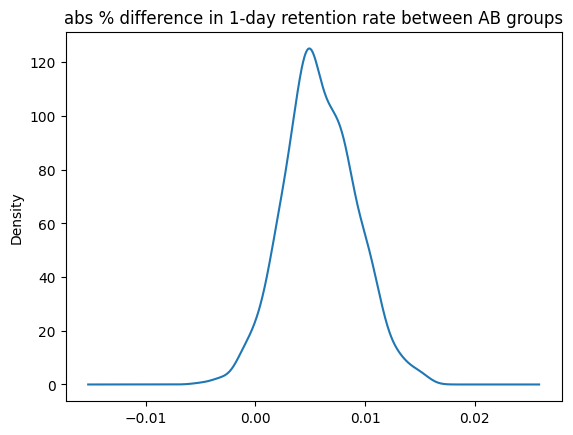

In [ ]:
# adding a column with the % difference between each AB-group
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)

#plotting the bootstrap % diff
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('abs % difference in 1-day retention rate between AB groups')

#calculating the probability that 1-day retention rate is higher when gate is at level 30
print('Probability that 1-day retention is higher when the gate is at level 30:',(boot_1d['diff']>0).mean())

From above chart, the most likely absolute % difference is close to 1%, and over 96% of the distribution is above 0, in favor of gate 30.

### 3.2.2 z-test

* primary metric: 1-day retention rate
* null hypothesis, 1-day retention rates for both version are the same
* alternative hypothesis, version 40 1-day retention rate is higher than version 30

In [21]:
def z_test(p1,p0,n1,n0):
  delta = p1-p0
  p=(p1*n1+p0*n0)/(n1+n0) #pooled sample proportion
  return delta/np.sqrt(p*(1-p)*(1/n1+1/n0))
  #The standard error (SE) measures the variability in the difference between the sample proportions of the two groups.

The reason for using a pooled proportion is to account for the variability in both groups and obtain **a more robust estimate **of the underlying population proportion.

The specific formula for the SE is derived from mathematical manipulation of the properties of binomial distributions. It takes into account the combined variance from both groups and the sizes of those groups.
* SD for binomial distribution = sqrt(n**p**(1-p))

In [42]:
p0 = df[df['version'] == 'gate_30']['retention_1'].mean()
p1 = df[df['version'] == 'gate_40']['retention_1'].mean()
n0 = df[df['version'] == 'gate_30']['retention_1'].count()
n1 = df[df['version'] == 'gate_40']['retention_1'].count()
p0, p1, n0, n1

(0.4481879194630872, 0.44228274967574577, 44700, 45489)

In [26]:
z1 = z_test(p1,p0,n1,n0)
z1

-1.7840862247974725

In [27]:
from scipy.stats import norm
p_value_1 = 1-norm.cdf(z1)
p_value_1

0.9627951723515404

p value is 96%, we cannot reject null hypothesis, it is not statistically significant that move gate to round 40 will improve 1-day retention rate.

### 3.3.3 z-test in Statesmodels



In [30]:
import statsmodels.api as sm

In [33]:
count_30 = df[df['version'] == 'gate_30']['retention_1'].sum()
count_40 = df[df['version'] == 'gate_40']['retention_1'].sum()


In [34]:
z_score_1, p_value_1 = sm.stats.proportions_ztest([count_40,count_30],[n1,n0], alternative = 'larger')
z_score_1, p_value_1

(-1.7840862247974725, 0.9627951723515404)

same to our self-defined z_test function, P value is 96%, we cannot reject null hypothesis, propose to keep current version, with gate set at round 30.

# 4.comparing 7-day retention

### 4.1 bootstrapping

<Axes: ylabel='Density'>

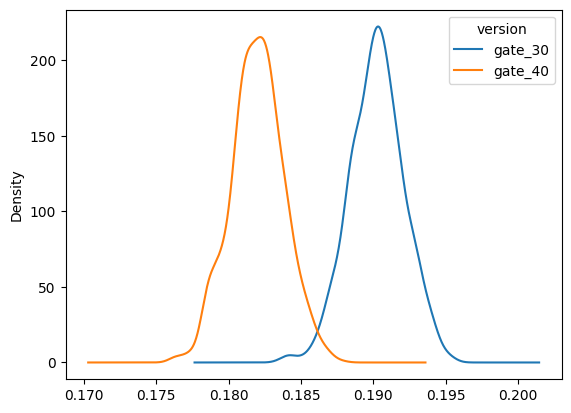

In [55]:
# creating an list with bootstrapped means for each AB-group
boot_7d = []

for i in range(1000):
  boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
  boot_7d.append(boot_mean)

# transforming the list to DataFrame
boot_7d = pd.DataFrame(boot_7d)

# A kernel density estimate plot of the boot strap distributions
boot_7d.plot(kind='density')

above 7-day retention rate plot is showing similar distribution with 1-day retention sampling distribution. looks like 7-day retention rate is also higher when gate is at 30.
let's plot the % difference to get a closer look.

Probability that 7-day retention is higher when the gate is at level 30: 0.959


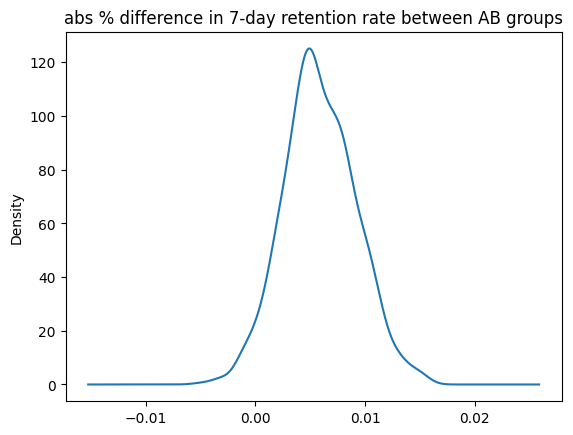

In [ ]:
# adding a column with the % difference between each AB-group
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)

#plotting the bootstrap % diff
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('abs % difference in 7-day retention rate between AB groups')

#calculating the probability that 1-day retention rate is higher when gate is at level 30
print('Probability that 7-day retention is higher when the gate is at level 30:',(boot_7d['diff']>0).mean())

From above chart, the most likely absolute % difference is around 0.5%, and over 95% of the distribution is above 0, in favor of gate 30.

### 4.2 z-test

* primary metric: 7-day retention rate
* null hypothesis, 7-day retention rates for both version are the same
* alternative hypothesis, version 40 7-day retention rate is higher than version 30

In [56]:
p3 = df[df['version'] == 'gate_30']['retention_7'].mean()
p4 = df[df['version'] == 'gate_40']['retention_7'].mean()
n3 = df[df['version'] == 'gate_30']['retention_7'].count()
n4 = df[df['version'] == 'gate_40']['retention_7'].count()
p3, p4, n3, n4

(0.19020134228187918, 0.18200004396667327, 44700, 45489)

In [57]:
z7 = z_test(p4, p3, n4, n3)
z7

-3.164358912748191

In [58]:
p_value_7 = 1-norm.cdf(z7)
p_value_7

0.9992228750121929

similar to z-test for 1-day retention rate, p value is 96%, we cannot reject null hypothesis, it is not statistically significant that move gate to round 40 will improve 7-day retention rate.

### 4.3 z-test in statesmodels

In [59]:
count_30_7 = df[df['version'] == 'gate_30']['retention_7'].sum()
count_40_7 = df[df['version'] == 'gate_40']['retention_7'].sum()

In [60]:
z_score_7, p_value_7 = sm.stats.proportions_ztest([count_40_7,count_30_7],[n4,n3],alternative = 'larger')
z_score_7, p_value_7

(-3.164358912748191, 0.9992228750121929)